✅ TPU libraries imported
✅ Using BASE_DIR = /kaggle/input/ds-data/ds
Running on: xla:0
🔄 Loading datasets …
Classes: ['0', '1', '2', '3', '4']
Sizes  : 29840 train | 6796 val | 8691 test
📊 Model parameters: 11,243,077

🚀 Training Model...
📋 Config: LR=0.0003, WD=0.0005, Dropout=0.3, Batch=32, ImgSize=224

📅 Epoch 1/50
Train: 0.4225/1.4878 | Val: 0.5806/1.1574 | Test: 0.5974/1.1340
Learning Rate: 0.000300
  💾 Saved new best model (Val Acc: 0.5806)
  ✨ New best validation: 0.5806
  Best Val: 0.5806 | Patience: 0/15

📅 Epoch 2/50
Train: 0.5405/1.2444 | Val: 0.6461/1.0715 | Test: 0.6722/1.0440
Learning Rate: 0.000300
  💾 Saved new best model (Val Acc: 0.6461)
  ✨ New best validation: 0.6461
  Best Val: 0.6461 | Patience: 0/15

📅 Epoch 3/50
Train: 0.5862/1.1803 | Val: 0.6438/1.0830 | Test: 0.6707/1.0622
Learning Rate: 0.000300
  Best Val: 0.6461 | Patience: 1/15

📅 Epoch 4/50
Train: 0.6144/1.1471 | Val: 0.6733/1.0216 | Test: 0.6912/0.9877
Learning Rate: 0.000300
  💾 Saved new best model (Va

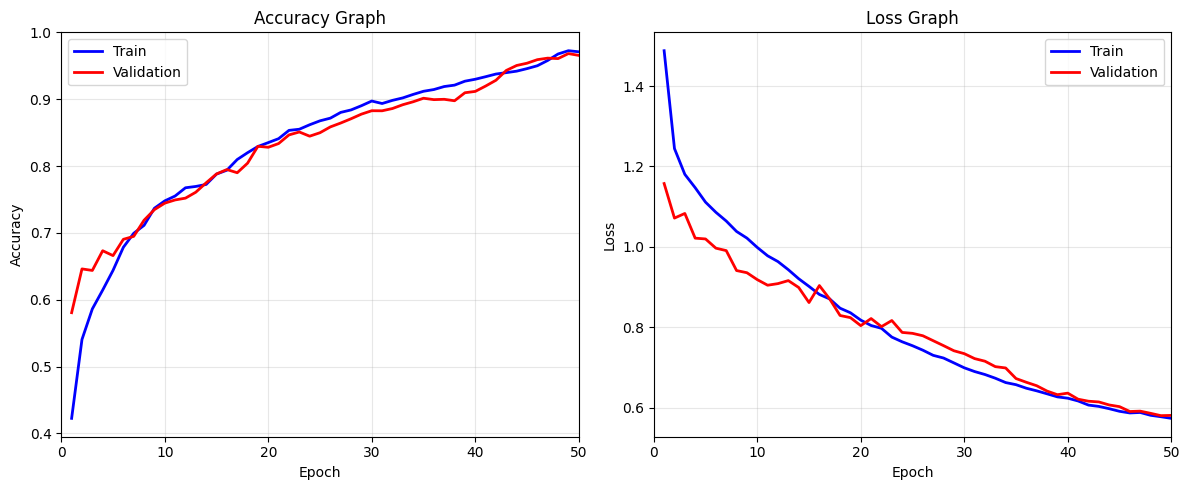


✅ Stable Training Completed!
💾 Best model saved at: /kaggle/working/stable.pt


In [27]:
import os, random, time, itertools, shutil, pathlib, pprint, math
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ---------- TPU imports ----------
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.utils.utils as xu
    TPU_AVAILABLE = True
    print("✅ TPU libraries imported")
except ImportError:
    TPU_AVAILABLE = False
    print("❌ TPU libraries not available – using CPU/GPU")

# ==========================================================
# 1. Dataset paths (FIXED + AUTO-SCAN)
# ==========================================================
BASE_DIR = "/kaggle/input/ds-data/ds"
TRAIN_DIR, VAL_DIR, TEST_DIR = [os.path.join(BASE_DIR, d) for d in ("train", "val", "test")]

def find_dataset_root(search_root="/kaggle/input", expect=("train","val","test")):
    for root, dirs, _ in os.walk(search_root):
        if all(d in dirs for d in expect):
            return root
    return None

if not all(os.path.exists(p) for p in [TRAIN_DIR, VAL_DIR, TEST_DIR]):
    auto = find_dataset_root()
    if auto:
        print(f"🔄 Auto-detected dataset at: {auto}")
        BASE_DIR = auto
        TRAIN_DIR, VAL_DIR, TEST_DIR = [os.path.join(BASE_DIR, d) for d in ("train","val","test")]
    else:
        raise FileNotFoundError("Dataset folders train/val/test not found.")

print(f"✅ Using BASE_DIR = {BASE_DIR}")

# ==========================================================
# 2. STABILIZED Hyper-parameters 
# ==========================================================
NUM_CLASSES  = 5
IMG_SIZE     = 224                                  # Standard ResNet input size
BATCH_SIZE   = 32 if TPU_AVAILABLE else 16         # Smaller for stability
EPOCHS       = 50                                  
PATIENCE     = 15                                  # Higher patience
MIN_DELTA    = 1e-4                                
LR           = 3e-4 if TPU_AVAILABLE else 2e-4     # Much lower LR for stability
WEIGHT_DECAY = 5e-4                                # Higher regularization
NUM_WORKERS  = 8 if TPU_AVAILABLE else 4
DROPOUT_RATE = 0.3                                 # Higher dropout

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if TPU_AVAILABLE:
    xm.set_rng_state(SEED)
elif torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True      # For reproducibility
    torch.backends.cudnn.benchmark = False

device = xm.xla_device() if TPU_AVAILABLE else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# ==========================================================
# 3. CONSERVATIVE Data Augmentation (Reduced intensity)
# ==========================================================
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE + 16, IMG_SIZE + 16)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15, fill=0),          # Reduced rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1), # Reduced jitter
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)), # Reduced erasing
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ==========================================================
# 4. Datasets & Dataloaders
# ==========================================================
print("🔄 Loading datasets …")
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=not TPU_AVAILABLE, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=not TPU_AVAILABLE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=not TPU_AVAILABLE)

print("Classes:", train_ds.classes)
print(f"Sizes  : {len(train_ds)} train | {len(val_ds)} val | {len(test_ds)} test")

# ==========================================================
# 5. STABLE Model Architecture (ResNet18 with better regularization)
# ==========================================================
class StableResNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE):
        super().__init__()
        # Use ResNet18 for better stability
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        # Simpler, more stable classifier
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, num_classes)
        )
        
        # Proper initialization
        for module in self.backbone.fc.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.backbone(x)

model = StableResNet().to(device)
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# ==========================================================
# 6. STABLE Loss Function and Optimizer
# ==========================================================
# Standard CrossEntropy with label smoothing
class StableLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        
    def forward(self, pred, target):
        log_probs = torch.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

criterion = StableLoss(smoothing=0.1)

# Conservative optimizer settings
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999))

# Stable learning rate schedule
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=True
)

# ==========================================================
# 7. IMPROVED Early Stopping
# ==========================================================
class StableEarlyStop:
    def __init__(self, patience=PATIENCE, delta=MIN_DELTA):
        self.patience, self.delta = patience, delta
        self.best_val, self.count, self.weights = 0.0, 0, None
        self.history = {'val_acc': [], 'train_acc': [], }
    
    def __call__(self, val_acc, train_acc, net):
        gap = train_acc - val_acc
        self.history['val_acc'].append(val_acc)
        self.history['train_acc'].append(train_acc)
        
        # Simple improvement check
        if val_acc > self.best_val + self.delta:
            self.best_val, self.count = val_acc, 0
            self.weights = {k: v.cpu().clone() for k, v in net.state_dict().items()}
            print(f"  ✨ New best validation: {val_acc:.4f}")
        else:
            self.count += 1
            
        print(f"  Best Val: {self.best_val:.4f} | Patience: {self.count}/{self.patience}")
        
        if self.count >= self.patience:
            print("⛔ Early stopping - loading best weights")
            net.load_state_dict(self.weights)
            return True
        return False

early_stop = StableEarlyStop()
best_acc, save_path = 0.0, "/kaggle/working/stable.pt"

# ==========================================================
# 8. CLEAN Training and Evaluation Functions (No Live Tracking)
# ==========================================================
def train_loop(loader):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    if TPU_AVAILABLE:
        loader = pl.ParallelLoader(loader, [device]).per_device_loader(device)

    for imgs, lbls in loader:  # No tqdm progress bar
        if not TPU_AVAILABLE:
            imgs, lbls = imgs.to(device), lbls.to(device)
        
        # Simple forward pass - no mixup
        outs = model(imgs)
        loss = criterion(outs, lbls)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Conservative gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        xm.optimizer_step(optimizer) if TPU_AVAILABLE else optimizer.step()
        
        loss_sum += loss.item() * imgs.size(0)
        correct += (outs.argmax(1) == lbls).sum().item()
        total += imgs.size(0)
        
        if TPU_AVAILABLE: xm.mark_step()
    
    return loss_sum/total, correct/total

def eval_loop(loader, desc="Eval"):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    if TPU_AVAILABLE:
        loader = pl.ParallelLoader(loader, [device]).per_device_loader(device)

    with torch.no_grad():
        for imgs, lbls in loader:  # No tqdm progress bar
            if not TPU_AVAILABLE:
                imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            loss = criterion(outs, lbls)
            
            loss_sum += loss.item() * imgs.size(0)
            correct += (outs.argmax(1) == lbls).sum().item()
            total += imgs.size(0)
            if TPU_AVAILABLE: xm.mark_step()
    
    return loss_sum/total, correct/total

# ==========================================================
# 9. STABLE Training Loop
# ==========================================================
print("\n🚀 Training Model...")
print(f"📋 Config: LR={LR}, WD={WEIGHT_DECAY}, Dropout={DROPOUT_RATE}, Batch={BATCH_SIZE}, ImgSize={IMG_SIZE}")

# Track metrics for analysis
metrics_history = {
    'train_acc': [], 'val_acc': [], 'test_acc': [], 
    'train_loss': [], 'val_loss': []
}

for epoch in range(1, EPOCHS + 1):
    print(f"\n📅 Epoch {epoch}/{EPOCHS}")
    
    tr_loss, tr_acc = train_loop(train_loader)
    va_loss, va_acc = eval_loop(val_loader, "Val")
    
    # Test evaluation every 10 epochs
    if epoch % 10 == 0 or epoch <= 5:
        te_loss, te_acc = eval_loop(test_loader, "Test")
        print(f"Train: {tr_acc:.4f}/{tr_loss:.4f} | Val: {va_acc:.4f}/{va_loss:.4f} | Test: {te_acc:.4f}/{te_loss:.4f}")
        metrics_history['test_acc'].append(te_acc)
    else:
        te_acc = None
        print(f"Train: {tr_acc:.4f}/{tr_loss:.4f} | Val: {va_acc:.4f}/{va_loss:.4f}")
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Store metrics
    metrics_history['train_acc'].append(tr_acc)
    metrics_history['val_acc'].append(va_acc)
    metrics_history['train_loss'].append(tr_loss)
    metrics_history['val_loss'].append(va_loss)
    

    # Save best model
    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({
            "model": model.state_dict(),
            "class2idx": train_ds.class_to_idx,
            "config": {
                "dropout": DROPOUT_RATE,
                "lr": LR,
                "weight_decay": WEIGHT_DECAY,
                "batch_size": BATCH_SIZE,
                "img_size": IMG_SIZE,
                "architecture": "ResNet18-Stable"
            },
            "metrics_history": metrics_history,
            "epoch": epoch
        }, save_path)
        print(f"  💾 Saved new best model (Val Acc: {best_acc:.4f})")

    # Step scheduler
    scheduler.step(va_acc)

    # Early stopping check
    if early_stop(va_acc, tr_acc, model):
        break

# ==========================================================
# 10. Final Evaluation and Analysis
# ==========================================================
print("\n🏁 Final evaluation with best model...")
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint["model"])

# Test evaluation
te_loss, te_acc = eval_loop(test_loader, "Final Test")
va_loss, va_acc = eval_loop(val_loader, "Final Val")

print(f"\n🎯 FINAL RESULTS:")
print(f"📊 Test Accuracy: {te_acc:.4f} ({te_acc*100:.2f}%)")
print(f"📊 Test Loss: {te_loss:.4f}")
print(f"📊 Val Accuracy: {va_acc:.4f} ({va_acc*100:.2f}%)")

# Detailed evaluation
print("\n📊 Generating detailed evaluation...")
preds, targs, probs = [], [], []
model.eval()
test_iter = pl.ParallelLoader(test_loader, [device]).per_device_loader(device) if TPU_AVAILABLE else test_loader

with torch.no_grad():
    for imgs, lbls in test_iter:  # No tqdm progress bar for clean output
        if not TPU_AVAILABLE:
            imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        probabilities = torch.softmax(outputs, dim=1)
        predicted = outputs.argmax(1)
        
        preds.extend(predicted.cpu().tolist())
        targs.extend(lbls.cpu().tolist())
        probs.extend(probabilities.cpu().tolist())
        if TPU_AVAILABLE: xm.mark_step()

# Plot training curves
if len(metrics_history['train_acc']) > 5:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    epochs = range(1, len(metrics_history['train_acc']) + 1)
    plt.plot(epochs, metrics_history['train_acc'], 'b-', label='Train', linewidth=2)
    plt.plot(epochs, metrics_history['val_acc'], 'r-', label='Validation', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Graph')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics_history['train_loss'], 'b-', label='Train', linewidth=2)
    plt.plot(epochs, metrics_history['val_loss'], 'r-', label='Validation', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Graph')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("/kaggle/working/stable_training_curves.png", dpi=150, bbox_inches="tight")
    plt.show()

print(f"\n✅ Stable Training Completed!")
print(f"💾 Best model saved at: {save_path}")